In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle  # ⬅️ Этот импорт обязателен!
import imageio
import os

In [44]:


# ------------------ Пользовательская среда GridWorld ------------------
class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.state = (0, 0)
        self.goal = (size - 1, size - 1)  # (x, y)
        self.action_space = 4  # 0: up, 1: right, 2: down, 3: left
        self.observation_space = size * size  # flat state space

    def reset(self):
        self.state = (0, 0)
        return self._to_flat(self.state)

    def _to_flat(self, pos):
        x, y = pos
        return x * self.size + y

    def step(self, action):
        x, y = self.state
        if action == 0 and x > 0:
            x -= 1
        elif action == 1 and y < self.size - 1:
            y += 1
        elif action == 2 and x < self.size - 1:
            x += 1
        elif action == 3 and y > 0:
            y -= 1

        new_state = (x, y)
        done = new_state == self.goal
        reward = 1.0 if done else -0.01
        self.state = new_state
        return self._to_flat(new_state), reward, done


In [46]:

# ------------------ Функция преобразования индекса в координаты ------------------
def idx_to_pos(idx, size):
    return (idx // size, idx % size)

In [48]:
# ------------------ Визуализация текущего состояния и сохранение кадра ------------------
def visualize_and_save_frame(env, state_idx, episode, step, frames_folder="frames"):
    grid_size = env.size
    grid = np.zeros((grid_size, grid_size, 3))  # RGB

    x, y = idx_to_pos(state_idx, grid_size)
    gx, gy = env.goal  # цель как (x, y)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(grid)

    # Рисуем решётку
    for i in range(grid_size):
        for j in range(grid_size):
            rect = Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, color="black")
            ax.add_patch(rect)

    # Агент
    agent_rect = Rectangle((y - 0.4, x - 0.4), 0.8, 0.8, color="blue", label="Agent")
    ax.add_patch(agent_rect)

    # Цель
    goal_rect = Rectangle((gy - 0.4, gx - 0.4), 0.8, 0.8, color="green")
    ax.add_patch(goal_rect)

    ax.set_title(f"Episode {episode} | Step {step}")
    ax.axis("off")

    # Сохраняем кадр
    frame_path = os.path.join(frames_folder, f"frame_{step:03d}.png")
    plt.savefig(frame_path)
    plt.close(fig)

In [50]:

# ------------------ Модель A2C ------------------
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(ActorCritic, self).__init__()
        self.shared = nn.Linear(num_inputs, 64)
        self.actor = nn.Linear(64, num_actions)
        self.critic = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.shared(x))
        return self.actor(x), self.critic(x)


# ------------------ Гиперпараметры ------------------
env = GridWorld()
state_size = env.observation_space
action_size = env.action_space
n_episodes = 100
gamma = 0.99
lr = 3e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ActorCritic(state_size, action_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


In [52]:


# ------------------ Функция обучения ------------------
def train():
    win_history = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        transitions = []

        while True:
            # One-hot encoding
            state_tensor = torch.zeros(1, state_size)
            state_tensor[0, state] = 1.0
            state_tensor = state_tensor.to(device)

            logits, value = model(state_tensor)
            policy = Categorical(logits=logits)
            action = policy.sample()

            next_state, reward, done = env.step(action.item())
            total_reward += reward

            transitions.append((state_tensor, action, reward, value, policy.log_prob(action)))

            state = next_state

            if done:
                break
        # Обучение
        loss = 0
        returns = []
        R = 0
        for t in reversed(range(len(transitions))):
            R = transitions[t][2] + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        for i, (state_tensor, action, _, value, log_prob) in enumerate(transitions):
            advantage = returns[i] - value.item()
            actor_loss = -log_prob * advantage
            critic_loss = F.mse_loss(value, returns[i].unsqueeze(0))
            loss += actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Логирование побед
        won = total_reward > 0.9
        win_history.append(1 if won else 0)

        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, {'✅ Win' if won else '❌ Lose'}")

    torch.save(model.state_dict(), "a2c_gridworld.pth")
    print("Модель сохранена.")
    plot_wins(win_history)
    save_video_from_agent(model, env)



In [54]:

# ------------------ График с победами ------------------
def plot_wins(wins):
    wins_smooth = np.convolve(wins, np.ones(10)/10, mode='valid')
    plt.plot(wins_smooth)
    plt.title("Win Rate Over Episodes (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.grid(True)
    plt.show()



C:\Users\chirkova_aa\AppData\Local\Temp\ipykernel_137580\589209778.py:43: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(value, returns[i].unsqueeze(0))


Episode 0, Total Reward: 0.59, ❌ Lose
Episode 1, Total Reward: 0.68, ❌ Lose
Episode 2, Total Reward: 0.75, ❌ Lose
Episode 3, Total Reward: 0.92, ✅ Win
Episode 4, Total Reward: 0.90, ❌ Lose
Episode 5, Total Reward: 0.19, ❌ Lose
Episode 6, Total Reward: 0.84, ❌ Lose
Episode 7, Total Reward: 0.17, ❌ Lose
Episode 8, Total Reward: 0.60, ❌ Lose
Episode 9, Total Reward: 0.72, ❌ Lose
Episode 10, Total Reward: 0.65, ❌ Lose
Episode 11, Total Reward: 0.91, ✅ Win
Episode 12, Total Reward: 0.88, ❌ Lose
Episode 13, Total Reward: 0.79, ❌ Lose
Episode 14, Total Reward: 0.55, ❌ Lose
Episode 15, Total Reward: 0.54, ❌ Lose
Episode 16, Total Reward: 0.86, ❌ Lose
Episode 17, Total Reward: 0.82, ❌ Lose
Episode 18, Total Reward: 0.68, ❌ Lose
Episode 19, Total Reward: 0.40, ❌ Lose
Episode 20, Total Reward: -0.38, ❌ Lose
Episode 21, Total Reward: 0.14, ❌ Lose
Episode 22, Total Reward: 0.75, ❌ Lose
Episode 23, Total Reward: 0.49, ❌ Lose
Episode 24, Total Reward: 0.95, ✅ Win
Episode 25, Total Reward: 0.75, ❌ Los

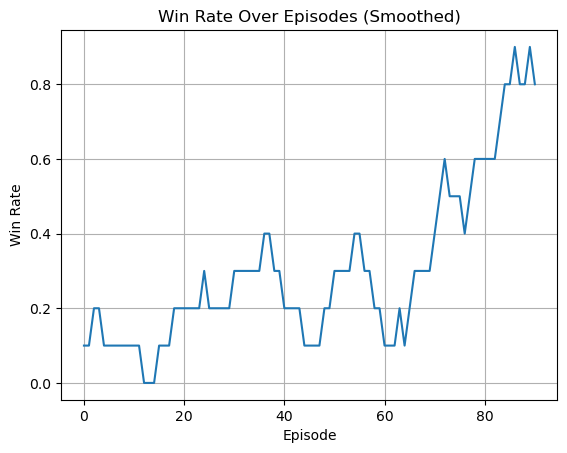

Запись видео с победой...
Видео сохранено как 'agent_win.gif'


C:\Users\chirkova_aa\AppData\Local\Temp\ipykernel_137580\2524832164.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(frames_folder, filename)))


In [56]:
# ------------------ Запись видео с агентом ------------------
from matplotlib.patches import Rectangle
def save_video_from_agent(model, env, video_name="agent_win.gif", max_steps=100):
    frames_folder = "frames"
    os.makedirs(frames_folder, exist_ok=True)

    model.eval()
    state = env.reset()
    done = False
    step = 0

    print("Запись видео с победой...")

    with torch.no_grad():
        while not done and step < max_steps:
            visualize_and_save_frame(env, state, 0, step, frames_folder)

            state_tensor = torch.zeros(1, env.observation_space)
            state_tensor[0, state] = 1.0
            logits, _ = model(state_tensor)
            action = logits.argmax().item()
            state, _, done = env.step(action)
            step += 1

    # Собираем кадры в GIF
    images = []
    for filename in sorted(os.listdir(frames_folder)):
        if filename.endswith(".png"):
            images.append(imageio.imread(os.path.join(frames_folder, filename)))

    imageio.mimsave(video_name, images, duration=0.3)
    print(f"Видео сохранено как '{video_name}'")

    # Очистка папки с кадрами
    for f in os.listdir(frames_folder):
        os.remove(os.path.join(frames_folder, f))


# ------------------ Запуск обучения ------------------
if __name__ == "__main__":
    train()